In [1]:
!git clone https://github.com/SalesforceAIResearch/uni2ts.git
%cd uni2ts
!pip install .


Cloning into 'uni2ts'...
remote: Enumerating objects: 847, done.
remote: Counting objects: 100% (356/356), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 847 (delta 250), reused 221 (delta 220), pack-reused 491 (from 1)
Receiving objects: 100% (847/847), 5.25 MiB | 17.30 MiB/s, done.
Resolving deltas: 100% (409/409), done.
/kaggle/working/uni2ts
Processing /kaggle/working/uni2ts
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [2]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset

# Load the ETTh1 dataset from Kaggle
# (Replace with the correct path to "ETTh1.csv" if stored in Kaggle's datasets directory)
df = pd.read_csv('/kaggle/input/etthigh/ETTh1.csv', parse_dates=['date'], index_col='date')
df['item_id'] = '1' 
# Ensure your data is structured with required columns
# Convert to PandasDataset format for Moirai
ds = PandasDataset.from_long_dataframe(df, target='HUFL', item_id='item_id')

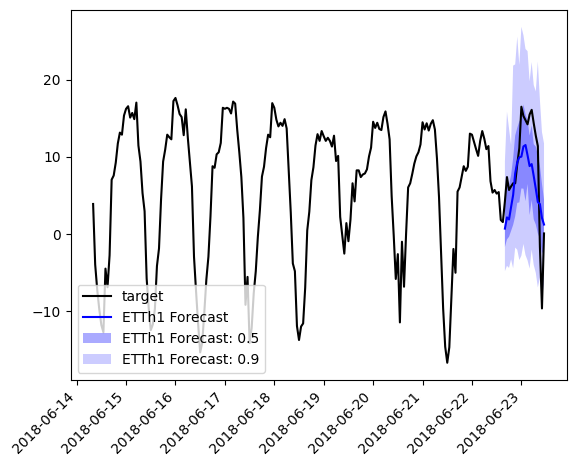

In [53]:
import torch
import matplotlib.pyplot as plt
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

# Define Moirai model parameters
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 20        # prediction length: any positive integer
CTX = 200       # context length: any positive integer
PSZ = "auto"    # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32        # batch size: any positive integer
TEST = 100      # test set length: any positive integer

# Split into train and test sets
train, test_template = split(ds, offset=-TEST)  # last TEST time steps are test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,    # non-overlapping windows
    distance=PDT
)

# Prepare pre-trained model with model weights from Hugging Face Hub
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,  # Multivariate target dimension
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

# Create predictor and forecast
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

# Plot one example of forecast vs actual
input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

plot_single(
    inp, 
    label, 
    forecast, 
    context_length=CTX,
    name="ETTh1 Forecast",
    show_label=True,
)
plt.show()


In [54]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = np.array(label['target'])      # Actual values
y_pred = np.array(forecast['median'])   # Forecasted mean values

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(y_true)
print(y_pred)

print(mse)
print(mae)


[ 4.21999979  7.36800003  5.69299984  6.16200018  6.56400013  6.56400013
  9.04199982 11.11900043 16.47699928 15.27099991 14.73600006 14.19999981
 15.47200012 16.07500076 14.33399963 12.72599983 11.38700008 -1.67400002
 -9.64500046  0.067     ]
[ 0.6936984  2.1477115  1.8796985  3.4986184  5.0558085  7.8551188
  9.2750435  9.929167  10.014809  11.335838  11.517956  10.18495
  8.790762   9.052264   7.501914   5.854109   4.1224566  3.874529
  2.0695398  1.2198081]
28.021590147640826
4.508213956654072
